In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

## 2D Convolution of a edge selector

In [6]:
"""
Write a program that performs a 2D convolution on the image 'hat_lady.png' with a 3x3 kernel, create a 
randomkernel with element values of your choice. Remember that if the kernel weights are too high or too 
low, the pixels get thresholded to 255 or 0 respectively. 
"""

def convolution(file_path, kernel):
    assert kernel.shape[0]==kernel.shape[1]
    
    #Read the image
    img = cv2.imread(file_path)
    
    #Convolution of the image
    conv_img = cv2.filter2D(img,-1,kernel)
    
    #Display the convolved image
    plt.figure(figsize=(6,6))
    plt.imshow(conv_img)
    plt.title('Convolution')

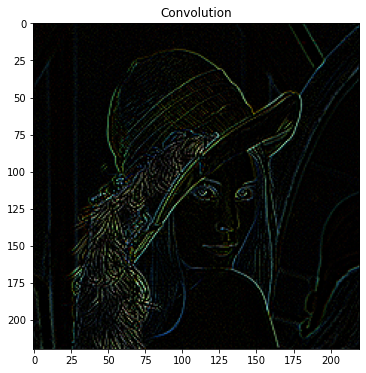

In [7]:
file_path = 'CV_PS_imgs/sample_imgs/hat_lady.png'

#Create kernel Edge Detection
kernel = np.array([[0,1,0],
                   [1,-4,1],
                   [0,1,0]])

convolution(file_path,kernel)

## Edge Detection using Canny

In [8]:
"""
write a Program that performs Gaussian Bluriing and Canny edge Detection on 'hat_lady.png',
Display the Canny Output.
"""

def canny_edge_detection(file_path,ksize,maxval,minval):
    #Read image
    img = cv2.imread(file_path,0)
    
    #Gaussian Blur
    Gauss_blur_img = cv2.GaussianBlur(img,ksize,0,0)
    
    #Canny edge detection
    canny_edge = cv2.Canny(Gauss_blur_img,minval,maxval,ksize)
    
    #Display
    plt.figure(figsize=(6,6))
    plt.title('Canny Edge Detector')
    plt.imshow(canny_edge, cmap='gray')

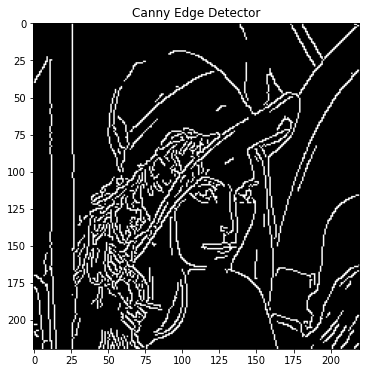

In [9]:
file_path = 'CV_PS_imgs/sample_imgs/hat_lady.png'
canny_edge_detection(file_path, 
                     ksize = (3,3),
                     maxval = 100, 
                     minval = 70)

# Lane Detection With Refined ROI Selection

In [31]:
"""Masking yellow and white, Guassian Blur and Canny Edge Detection"""
def img2edge(img,ksize,maxval,minval):
    
    #ColorSpace conversion
    color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #white thresholding-------------------------------------------------------------------------------------------------
    #white = 255,255,255 for RGB
    #Color threshold for whitish colors
    lower_thresholds = np.array([200,200,200])
    upper_thresholds = np.array([255,255,255])
    white_img = cv2.inRange(color_img, lower_thresholds,upper_thresholds)
    #___________________________________________________________________________________________________________________
    #Yellow thresholding------------------------------------------------------------------------------------------------
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    #thresholding yellow color using HSV
    lower_yellow = np.array([20,60,120])
    upper_yellow = np.array([40,255,255])
    yellow_img = cv2.inRange(hsv_img, lower_yellow,upper_yellow) 
    #___________________________________________________________________________________________________________________

    #combine the masks
    mask_yw = cv2.bitwise_or(yellow_img,white_img, mask=None)
    
    #Compute the final image for line detection
    yw_image = cv2.bitwise_and(grayscale, grayscale, mask=mask_yw)
    
    #Gaussian Blur
    Gauss_blur_img = cv2.GaussianBlur(yw_image,ksize,0,0)
    
    #Canny edge detection
    canny_edge = cv2.Canny(Gauss_blur_img,minval,maxval,ksize)
    
    return canny_edge


"""Select a region of the image to operate on"""
def roi_select(img,canny_output):
    
    #Choose a region of Image
    upper_left =(int(img.shape[1]*0.4),int(img.shape[0]*0.34))
    lower_left = (0,img.shape[0])
    upper_right = (int(img.shape[1]*0.5),int(img.shape[0]*0.34))
    lower_right = (img.shape[1],img.shape[0])
    
    vertices = [np.array([upper_left,lower_left,lower_right,upper_right])]
    #Create Mask
    mask = np.zeros_like(canny_output)
    cv2.fillPoly(mask,vertices,255)
    
    return cv2.bitwise_and(canny_output,mask)

"""This function will return the 4 coordinates of the ROI after it is 
    refined based on HoughLinesP function's output"""
def roi_refinement(img_shape,lines,canny_output,cutoff_ratio=0.2,Upper_line_spread=0.2, blvshift=0.01,blhspread=0.05):
    assert len(img_shape)>=2
    
    #img_shape = img.shape of the imported image
    #Cutoff_ratio = the precentage of the points from the top are removed
    #Upper_line_spread = the spread of the top of the trapezium
    #blvshift = the amount bottom of trapezium shifts in the y axis
    #blhspread = the amount bottom of trapezium spreads in the x axis
    #Returns = bitwise_and mask of the roi
    
    #Find the points need after the cutoff of the top 20% = cutoff_ratio
    x,y,z = lines.shape
    points = lines.reshape(int(2*x),2)
    cutoff = min(points[:,1])+int((max(points[:,1])-min(points[:,1]))*cutoff_ratio)
    cutoff_indices = np.where(points[:,1]>=cutoff)
    cutoff_points = points[cutoff_indices]

    #Find the bottom line points of the ROI trapezium
    minx = min(cutoff_points[:,0]) - int(img_shape[1]*blhspread)
    maxx = max(cutoff_points[:,0]) + int(img_shape[1]*blhspread)
    maxy = max(cutoff_points[:,1]) + int(img_shape[0]*blvshift)
    miny = min(cutoff_points[:,1]) - int(img_shape[0]*blvshift)

    #Find the top line points of the ROI trapezium 
    widthx = (maxx-minx)
    center = int(minx+widthx/2)
    minx2,maxx2 = int(center-widthx*Upper_line_spread), int(center+widthx*Upper_line_spread)
    
    #Upper_left,lower_left,lower_right,upper_right
    vertices = [np.array([(minx2,miny),(minx,maxy),(maxx, maxy),(maxx2, miny)])]
    #Create Mask
    mask = np.zeros_like(canny_output)
    cv2.fillPoly(mask,vertices,255)
    
    return cv2.bitwise_and(canny_output,mask), vertices

"""Hough Line prediction using Hough Transform for a straight Line"""
def draw_lines(img,canny_roi,rho_acc=2,theta_acc=np.pi/180,thresh=50,minLL=50,maxLG=100, num_of_lines=0):
    
    lines = cv2.HoughLinesP(canny_roi,rho_acc,theta_acc, 
                            threshold = thresh,
                            minLineLength = minLL,
                            maxLineGap = maxLG)
    
    #Define the mask
    mask = np.ones_like(canny_roi)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_line = img[:,:,1].copy()
    if num_of_lines==0:
        num_of_lines = len(lines)
    for i in range(int(num_of_lines)):
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(img_line,(x1,y1),(x2,y2),(0,0,255),5)
            cv2.line(mask,(x1,y1),(x2,y2),(0,0,255),5)
            
    mask = (255-mask)
    img[:,:,1] = img_line
    
    return img, mask, lines

In [36]:
def display_function(file_path,use_roi_refinement=1): #define the function specfic parameters inside
    
    img = cv2.imread(file_path)
    #Get the canny edge detection output
    canny_output = img2edge(img, ksize = (5,5), 
                            maxval = 100, 
                            minval = 50)
    
    #get region of interest output
    roi_output = roi_select(img,canny_output)
    
    #Get the line image
    img_result, line_img, lines = draw_lines(img,roi_output)
    if use_roi_refinement==1:
        #Perform ROI Refinement
        roi_output, vertices = roi_refinement(img.shape,lines,canny_output,0.06)
        #Get the line after roi refinement 
        img_result, line_img, lines = draw_lines(img, roi_output)
    
    #display all these
    fig,ax = plt.subplots(2,2,figsize=(10,7))
    ax[0,0].imshow(canny_output, cmap='gray')
    ax[0,0].set_title('Canny Edge Detector')
    ax[0,1].imshow(roi_output, cmap='gray')
    ax[0,1].set_title('Region of Interest Limitation')
    ax[1,0].imshow(line_img, cmap='gray')
    ax[1,0].set_title('Hough Line Image')
    ax[1,1].imshow(img_result)
    ax[1,1].set_title('Final Result')
    plt.tight_layout()
    return lines

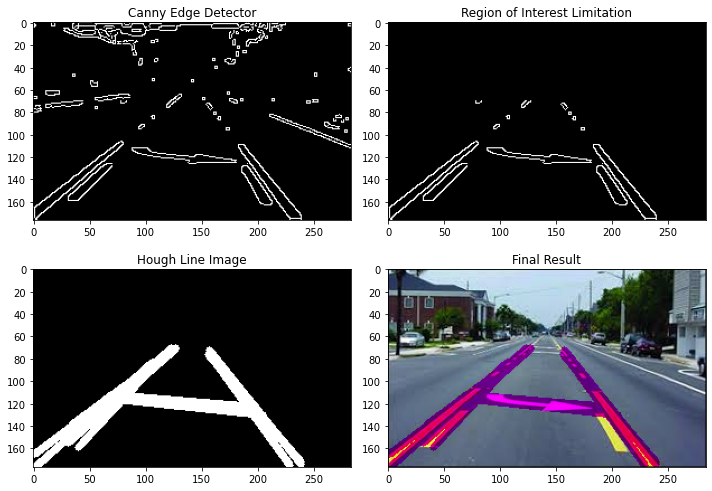

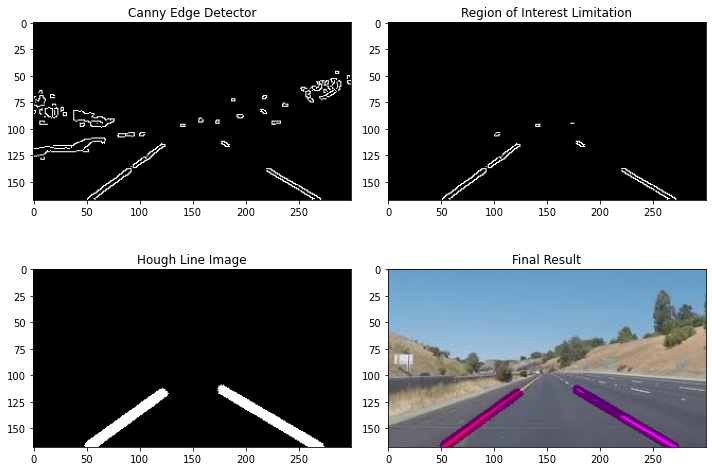

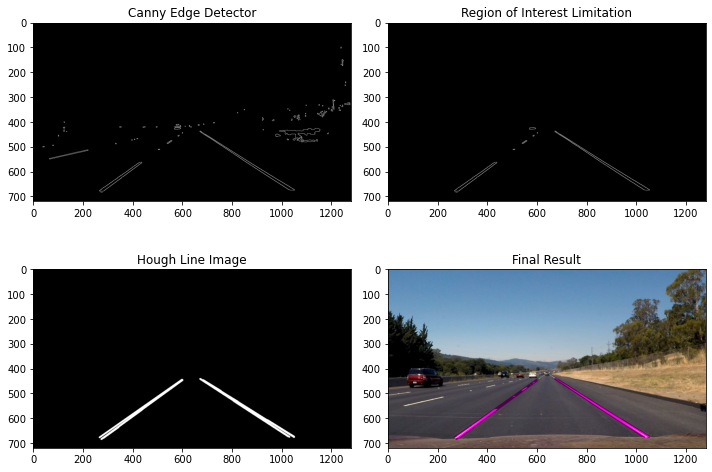

In [37]:
base_path = 'CV_PS_imgs/LD_test_imgs/'
file_names = ['test_img01.jpeg','test_img02.jpeg','test_img03.jpeg']

for i in file_names:
    file_path = base_path+str(i)
    lines = display_function(file_path,1)

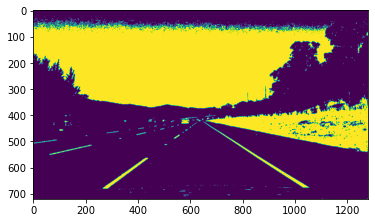

In [19]:
file_path = 'CV_PS_imgs/LD_test_imgs/test_img03.jpeg'
#Read image
img = cv2.imread(file_path,1)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,130,145, cv2.THRESH_BINARY)
plt.imshow(thresh)